# Network Analysis

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

Create user user_id list from preprocessed data

In [2]:
data = pd.read_csv('../output/preprocessed.csv')

user_dict = {}

# Function to add a user ID to a username
def add_user_id(username, user_id):
    if username in user_dict:
        user_dict[username].append(user_id)
    else:
        user_dict[username] = [user_id]

for index, row in data.iterrows():
    add_user_id(row['user'], row['user_id'])

{k: user_dict[k] for k in list(user_dict)[:5]}

{'danielwoodard': [1077866112],
 'nelsonjacqueline': [1089670430],
 'ihooper': [1007478642, 1007478642],
 'wrightnicholas': [1039258480],
 'michael51': [1021455936, 1096712805, 1022492390]}

In [3]:
# Create a new column 'user' in data by mapping user_id to user using user_id_dict
data['user'] = data['user_id'].map({v: k for k, v_list in user_dict.items() for v in v_list})
data.head()

,timestamp,text,text_id,user,user_id,hashtags,mentions,emojis,frequency,language
0,00:00:00,run business mean juggle countless administrat...,2018569761,danielwoodard,1077866112,"['#HRtech', '#businessmanagement']",[],[],1,en
1,00:00:00,liz truss walk linger shadow predecessor charl...,2092717718,nelsonjacqueline,1089670430,['#politics'],[],[],1,en
2,00:00:00,uk brace war government building london raise ...,2059143248,ihooper,1007478642,"['#Ukrainewashed', '#WarPreparedness']",[],['🇺🇦'],1,en
3,00:00:00,marry second cousin remove taboo think genetic...,2008209828,wrightnicholas,1039258480,"['#FamilyTree', '#GeneticFacts']",[],['🧬'],1,en
4,00:00:00,truly disgraceful indian national congress sto...,2001239278,michael51,1021455936,['#RationChorCongress'],[],"['🤦', '♂']",1,en


In [4]:
# Create a new dataframe with non-empty mentions
data_mentions = data[data['mentions'].apply(lambda x: len(eval(x)) > 0)][['user', 'mentions']]
print(f"Number of posts with mentions: {len(data_mentions)}")
data_mentions.head()

Number of posts with mentions: 36241


,user,mentions
5,ihooper,"['gabrieltaylor', 'lori57', 'timothy62', 'andr..."
7,mark89,"['mckenzieestrada', 'mckenzieestrada', 'shane2..."
8,andrea21,['jonathanreynolds']
10,kimberly05,['bethanycarroll']
11,kristen10,['wdavis']


In [5]:
# Load the graph data
graph_data = pd.read_csv('../data/graph.csv')

# Flatten the list of user IDs from user_dict
user_ids = set([user_id for user_ids in user_dict.values() for user_id in user_ids])

# Check if any user ID in the graph.csv is not in the user relation list
missing_users = set(graph_data['source']).union(set(graph_data['target'])) - user_ids

len(missing_users)

100

In [9]:
data['user'] = data['user_id'].map({v: k for k, v_list in user_dict.items() for v in v_list})
# Create a new dataframe by mapping both source and target columns
graph_data['source'] = graph_data['source'].map({v: k for k, v_list in user_dict.items() for v in v_list})
graph_data['target'] = graph_data['target'].map({v: k for k, v_list in user_dict.items() for v in v_list})
graph_data.head()

,source,target,weight
0,eleonard,jamessimon,1
1,eleonard,brianna65,1
2,eleonard,yschmidt,1
3,eleonard,justindavis,1
4,eleonard,kevin71,1


In [23]:
# Create a directed graph
G = nx.DiGraph()

# Iterate through the first 1000 rows of data_mentions
for index, row in data_mentions.iterrows():
        user = row['user']
        mentions = eval(row['mentions'])
        for mentioned_user in mentions:
                G.add_edge(user, mentioned_user)

In [ ]:
# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=True, node_size=50, font_size=8, alpha=0.7, arrows=True)
plt.title("User Mentions Network (First 1000 Rows)")
plt.show()

In [ ]:
# Apply the Louvain method for community detection
communities = nx.community.louvain_communities(G)

# Create a dictionary mapping each node to its community
partition = {}
for i, community in enumerate(communities):
	for node in community:
		partition[node] = i

# Add the partition information to the graph
nx.set_node_attributes(G, partition, 'community')

# Print the number of communities detected
num_communities = len(communities)
print(f"Number of communities detected: {num_communities}")

# Print the first 10 nodes with their community
list(partition.items())[:10]

Number of communities detected: 2055


[('gregory84', 0),
 ('webbvalerie', 0),
 ('xray', 0),
 ('colinabbott', 0),
 ('brandon30', 0),
 ('sarmstrong', 0),
 ('scottcarter', 0),
 ('brianjones', 0),
 ('emilyfitzpatrick', 0),
 ('telliott', 0)]

In [34]:
# Create a random layout for faster visualization
pos = nx.random_layout(G)

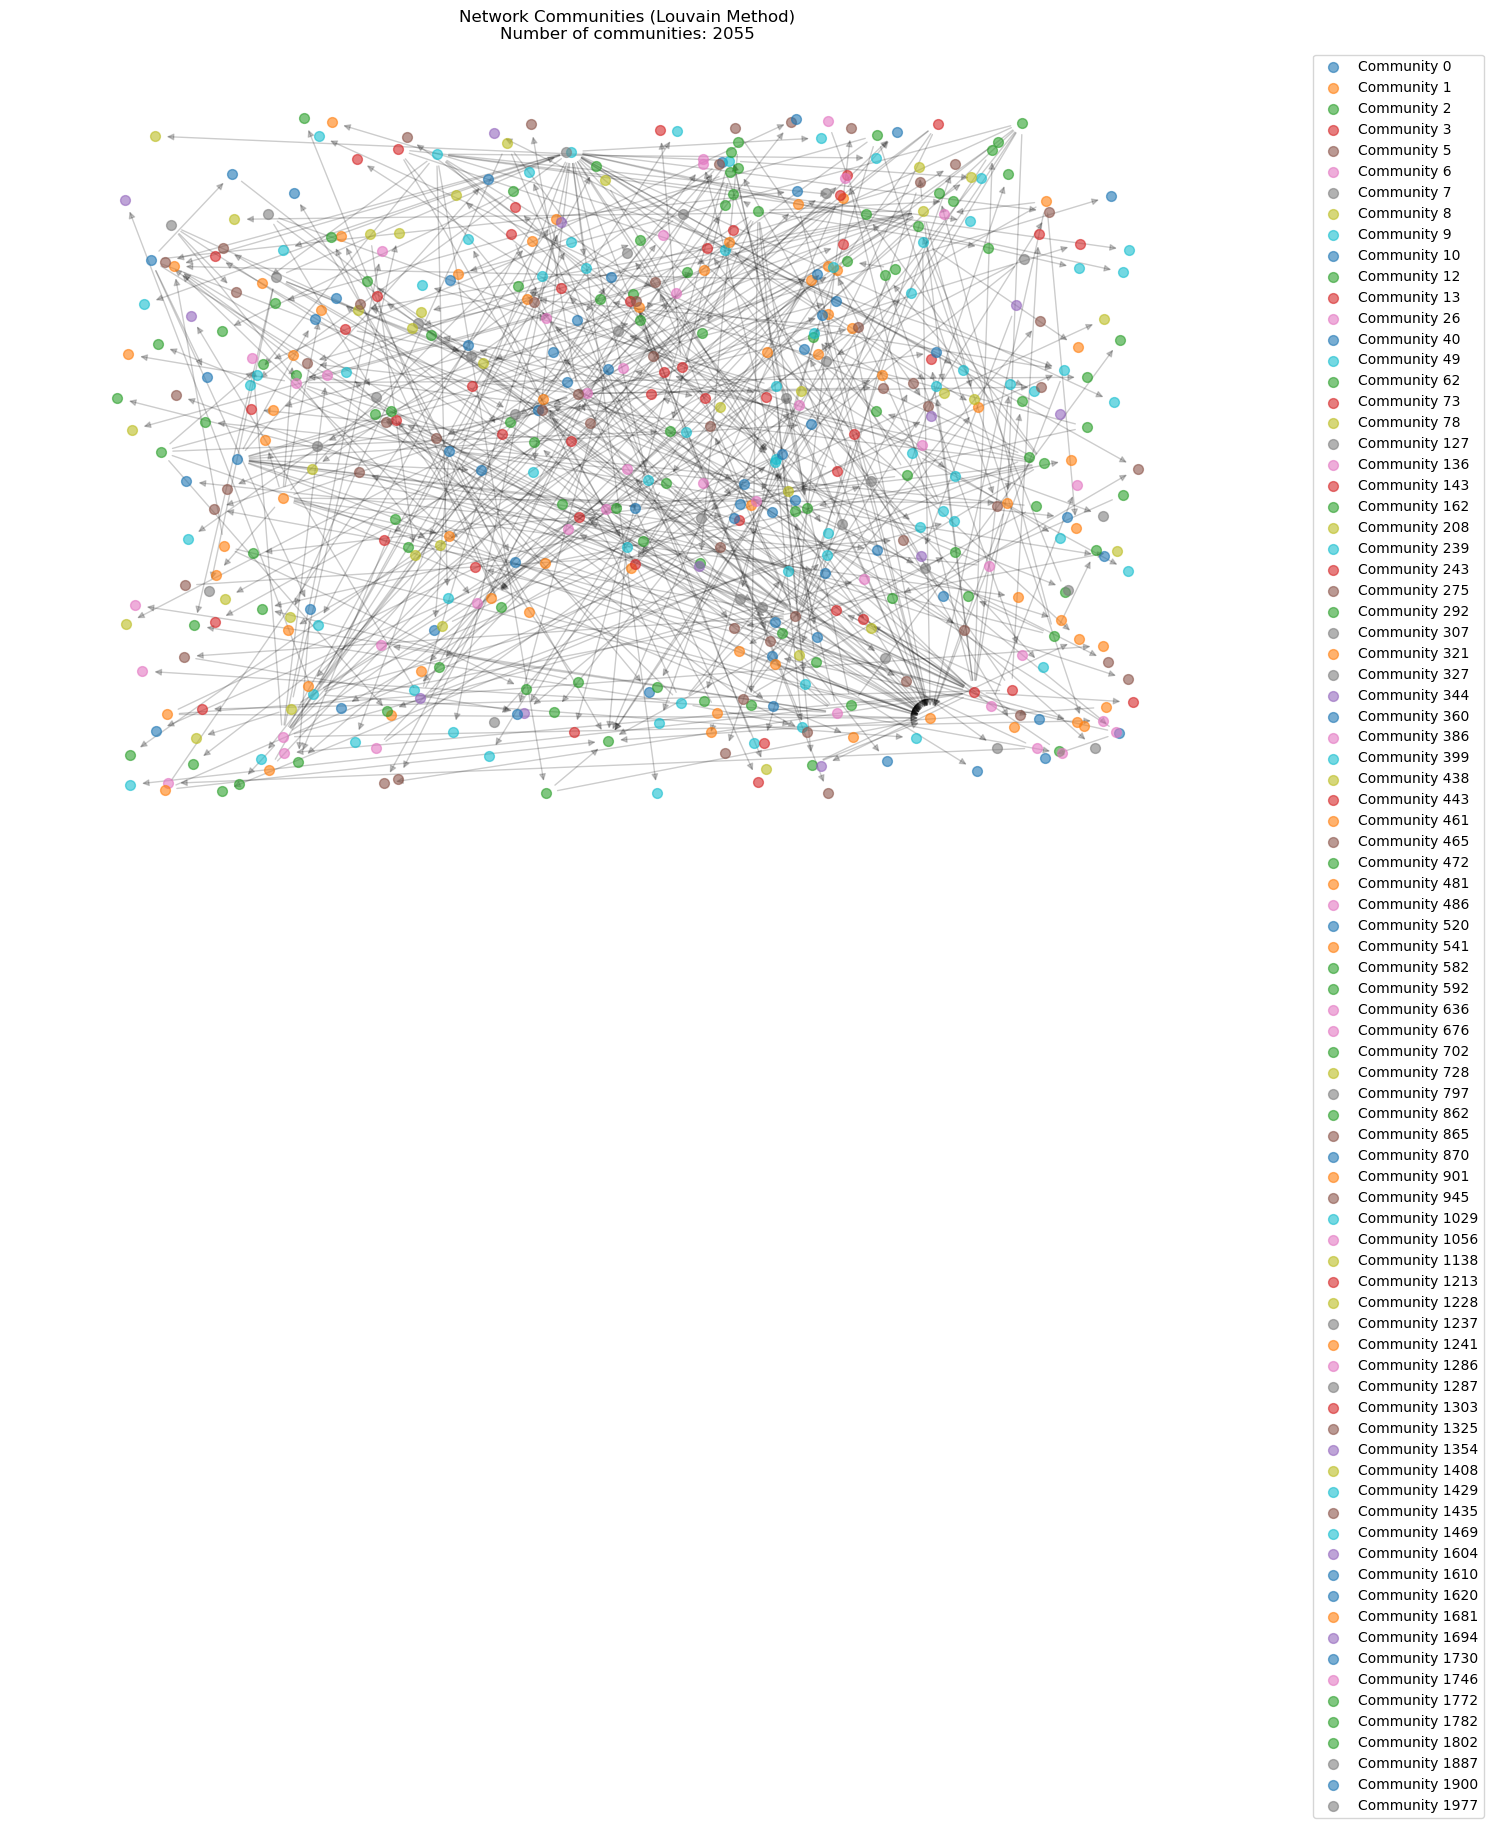

In [37]:
# Set up the plot
plt.figure(figsize=(15, 15))

# Limit the number of nodes to visualize
nodes_to_draw = list(G.nodes())[:500]

# Draw nodes with different colors for each community
for community_id in set(partition.values()):
    # Get list of nodes in current community
    nodes_in_community = [node for node in nodes_to_draw if partition[node] == community_id]
    
    # Draw nodes of the current community
    nx.draw_networkx_nodes(G, 
                          pos, 
                          nodelist=nodes_in_community,
                          node_size=50,
                          node_color=[f'C{community_id % 10}'],  # Cycle through 10 different colors
                          alpha=0.6,
                          label=f'Community {community_id}')

# Draw edges
edges_to_draw = [(u, v) for u, v in G.edges() if u in nodes_to_draw and v in nodes_to_draw]
nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, alpha=0.2)

# Add labels to nodes (commenting out to avoid cluttering, uncomment if needed)
# nx.draw_networkx_labels(G, pos, font_size=6)

plt.title(f"Network Communities (Louvain Method)\nNumber of communities: {num_communities}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('off')
plt.tight_layout()
plt.show()